# Objetivo:
Reconhecer a face de professores da EMAp com base em fotos achadas em buscas na Web. Para isso, utilizaremos Eigenfaces. A seguir, o passo-a-passo seguido no script:

## Passo a passo:


0. Selecionar nosso dataset, preenchido com imagens de professores, e completo com imagens de outro dataset encontrado na web.
1. Preparar o dataset, recortando as faces dos professores conforme necessário e colocando fundo branco.
2. Dessas imagens, pegar uma para treinamento e deixar as outras como teste (feita renomeando as de teste com números no final).
3. Recortar as imagens em um tamanho padronizado e convertê-las para preto e branco 8bits(feito em outro notebook).
4. Achatar as imagens, de matrizes para vetores
5. Calcular a face média das imagens de treinamento.
6. Normalizar as imagens de treinamento, de cada uma delas, subtrair a face média
7. Calcular a matriz de convariância,
8. Extrair os autovetores,
9. Calcular as Eigenfaces - Autovetores x Faces normalizadas
10. Calcular os pesos das imagens.  

# Fundamentação teórica

A aceitação ou recusa de uma imagem como face ou não se dá pela mensuração da sua diferença da imagem em contraste ao que o programa considera como face, isto é, o erro da projeção da imagem de entrada sobre o espaço vetorial gerado pelas eigenfaces.

O procedimento é feito colpasando as informações das imagens (pixels) em vetores unidimensionais, que irão compor as linhas da matriz. Com a matriz em mãos, podemos realizar sua decomposição SVD para descobrir seus autovalores e autovetores. Os autovetores, presentes na matriz U, terão o número de pixels de uma imagem, e, após o redimensionamento, podem ser visualizados como faces, isto é, "eigenfaces" (fazendo uma alusão ao termo "eigenvectors", ou autovetores, em inglês).

Por fim, o reconhecimento ou não de uma imagem de entrada como face se dará pelo erro da projeção no espaço gerado pelas eigenfaces. No caso deste ser numericamente maior que um limite imposto, será recusado. Caso seja menor, será aceito. De forma complementar, o nosso programa tenta identificar a qual imagem de treinamento o input se relaciona.

# Resultados

Tivemos duas abordagens similares impostas pela natureza do dataset. Na primeira abordagem, tentantos puramente reconhecer faces, e, se possível atrelá-las a um individuo, usando uma maçã como objeto de controle. Obtivemos taxa de sucesso de **11/18**. Na segunda, tentamos dar match dos inputs com os professores corretos, obtendo assim uma taxa de sucesso de **8/12**

### Importação os pacotes necessários

In [235]:
from matplotlib import pyplot as plt
from matplotlib.image import imread
import numpy as np
import os
import re

### Definindo o diretório das imagens, listando as mesmas e definindo a altura e largura das imagens.

In [236]:
dataset_path = "imgs/"
images  = os.listdir(dataset_path)
print(images)
width  = 195
height = 231

['bteste.jpg', 'dteste_1.jpg', 'Wagner.jpg', 'Yuri.jpg', 'Renato_1.jpg', 'Camacho_1.jpg', 'cteste_1.jpg', 'cteste.jpg', 'Yuri_1.jpg', 'Wagner_1.jpg', 'apple1_gray.jpg', 'dteste.jpg', 'Renato_7.jpg', 'ateste_1.jpg', 'Yuri_2.jpg', 'Wagner_2.jpg', 'Camacho_4.jpg', 'Renato_3.jpg', 'Camacho_3.jpg', 'Renato.jpg', 'Renato_2.jpg', 'Camacho_2.jpg', 'bteste_1.jpg', 'Camacho.jpg', 'Wagner_3.jpg', 'ateste.jpg']


## Aqui foram definidas as imagens de teste e de treinamento.
* train_images - Imagens de treinamento, usadas para identificar as outras, basicamente as que não possuem números no nome;
* test_images - Imagens que serão testadas no final. 

In [237]:
train_images = []
test_images = []
def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))
   
for i in images:
    test = hasNumbers(i)
    if test == False:
        train_images.append(i)
    else:
        test_images.append(i)

train_images

['bteste.jpg',
 'Wagner.jpg',
 'Yuri.jpg',
 'cteste.jpg',
 'dteste.jpg',
 'Renato.jpg',
 'Camacho.jpg',
 'ateste.jpg']

## Criação do array que irá conter as imagens de treinamento
training_tensor é criada como um ndarray de tamanho fixo (quantidade de imagens por (altura x largura)) e contém valores em formato float64.
A estrutura de repetição pegará cada imagem definida como de treinamento e adicionará ao Array. 

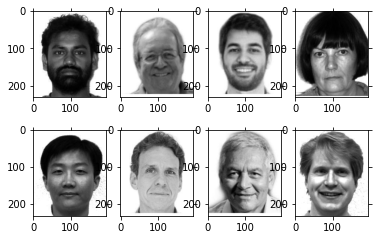

In [238]:
training_tensor = np.ndarray(shape=(len(train_images), height*width), dtype=np.float64)

for i in range(0, len(train_images)):
    img = plt.imread(dataset_path + train_images[i])
    training_tensor[i,:] = np.array(img, dtype='float64').flatten()
    plt.subplot(2,4,1+i)
    plt.imshow(img, cmap='gray')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()


O mesmo do passo anterior será feito com as imagens de teste.

Test Images:


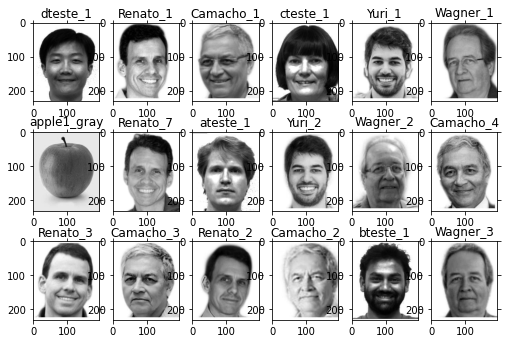

In [239]:
print('Test Images:')
testing_tensor = np.ndarray(shape=(len(test_images), height*width), dtype=np.float64) 
# Essa é a matriz com as imagens que serão testadas posteriormente

for i in range(len(test_images)):
    img = imread(dataset_path + test_images[i])
    testing_tensor[i,:] = np.array(img, dtype='float64').flatten()
    plt.subplot(3,6,1+i)
    plt.title(test_images[i].split('.')[0])
    plt.imshow(img, cmap='gray')
    plt.subplots_adjust(right=1.2, top=1.2)
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

## Face média

Nesse passo é feito o calculo da face média, recursivamente somando cada imagem do training_tensor ao array de zeros criado para a mean_face, e dividindo pelo total de faces ao final

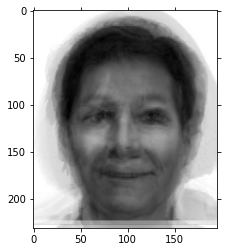

In [240]:
mean_face = np.zeros((1,height*width))

for i in training_tensor:
    mean_face = np.add(mean_face,i)

mean_face = np.divide(mean_face,float(len(train_images))).flatten()

plt.imshow(mean_face.reshape(height, width), cmap='gray')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

## Faces normalizadas

Aqui as faces são normalizadas, subtraindo de cada uma a face média.

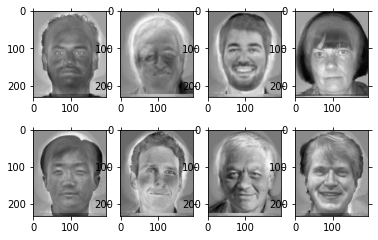

In [241]:
normalised_training_tensor = np.ndarray(shape=(len(train_images), height*width))

for i in range(len(train_images)):
    normalised_training_tensor[i] = np.subtract(training_tensor[i],mean_face)

for i in range(len(train_images)):
    img = normalised_training_tensor[i].reshape(height,width)
    plt.subplot(2,4,1+i)
    plt.imshow(img, cmap='gray')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

## Matriz de Covariância
Aqui, é calculada a matriz covariância das faces normalizadas, e, então, extraidos desta os autovalores e autovetores. Por conveniência, os mesmos são agrupados em pares e ordenados em ordem decrescente.
Matriz $$AA^t$$

In [242]:
cov_matrix = np.cov(normalised_training_tensor)
cov_matrix = np.divide(cov_matrix,8.0)

eigenvalues, eigenvectors, = np.linalg.eig(cov_matrix) # Autovalores e autovetores de AA^t, ou seja, matriz V

eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

# Ordenando:
eig_pairs.sort(reverse=True)
eigvalues_sort  = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvectors_sort = [eig_pairs[index][1] for index in range(len(eigenvalues))]

## Variância Cumulativa

Análise PCA dos componentes do treinamento, por meio do somatório da variância dos autovalores (já ordenados).

Proporção cumulativa de variância em relação aos componentes: 
[0.33338766 0.57810348 0.71562045 0.81654941 0.91096097 0.96489788
 1.         1.        ]


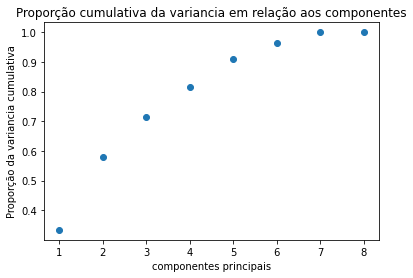

In [243]:
var_comp_sum = np.cumsum(eigvalues_sort)/sum(eigvalues_sort)

print(f"Proporção cumulativa de variância em relação aos componentes: \n{var_comp_sum}")

num_comp = range(1,len(eigvalues_sort)+1)
plt.title('Proporção cumulativa da variancia em relação aos componentes')
plt.xlabel('componentes principais')
plt.ylabel('Proporção da variancia cumulativa')

plt.scatter(num_comp, var_comp_sum)
plt.show()

## Matriz $$V^t$$

In [244]:
reduced_data = np.array(eigvectors_sort[:7]).transpose() # Matriz V^t
reduced_data

array([[-0.35099908,  0.39901424, -0.00586678,  0.12124807, -0.45152026,
         0.47611397, -0.38379254],
       [-0.287197  , -0.51327757,  0.5856991 ,  0.38290987, -0.08602526,
        -0.09261954,  0.15304213],
       [-0.06340159, -0.06902412, -0.62606537,  0.33413226,  0.0911486 ,
         0.19541926,  0.56224277],
       [ 0.86992091, -0.01853928,  0.13100204,  0.05903928, -0.29580439,
         0.0987027 , -0.00206784],
       [-0.11698869,  0.51841604,  0.0937055 , -0.1786501 , -0.17037371,
        -0.6598834 ,  0.29561558],
       [ 0.03744889, -0.13931554, -0.32521257,  0.24315438,  0.31343611,
        -0.41073468, -0.64988947],
       [-0.12955438, -0.45493509, -0.17411105, -0.77241896, -0.13984361,
         0.06339945, -0.02698687],
       [ 0.04077094,  0.2776613 ,  0.32084914, -0.1894148 ,  0.73898253,
         0.32960223,  0.05183624]])

In [245]:
eigenfaces = np.dot(training_tensor.transpose(),reduced_data) # Sendo u = Av^t
eigenfaces = eigenfaces.transpose() # Eigenfaces

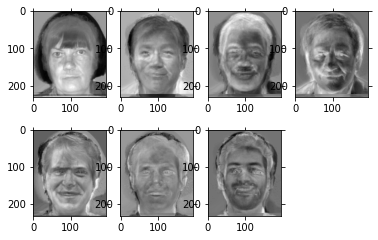

In [246]:
for i in range(eigenfaces.shape[0]):
    img = eigenfaces[i].reshape(height,width)
    plt.subplot(2,4,1+i)
    plt.imshow(img, cmap='gray')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

## Reconhecimento facial
Os pesos são o produto escalar das eigenfaces com cada face de treinamento normalizada.

In [247]:
weights = np.array([np.dot(eigenfaces,i) for i in normalised_training_tensor])
weights

array([[-4.33701228e+07,  1.75629373e+08,  3.33928865e+07,
         4.70076150e+06, -1.13156324e+08,  5.90386547e+07,
        -9.67476261e+06],
       [-1.45265003e+08, -1.82687875e+08,  5.21652551e+07,
         4.27680640e+07,  4.63435434e+07, -3.06045661e+07,
         2.66598155e+06],
       [-6.13644033e+07, -6.38920448e+07, -1.03311915e+08,
         3.68074411e+07,  5.04578797e+07, -9.83630406e+06,
         1.71256416e+07],
       [ 3.93751381e+08,  1.27139427e+08,  7.28073478e+07,
        -5.80290094e+06, -1.43559478e+08,  6.05639849e+07,
         5.37228297e+06],
       [-3.29908494e+05,  1.66201751e+08,  3.07684463e+07,
        -2.12667539e+07, -5.40767817e+07, -1.61196448e+07,
         1.18375005e+07],
       [-6.55328504e+07, -1.23180313e+08, -8.12429379e+07,
         3.16748520e+07,  1.08548574e+08, -5.94331226e+07,
        -2.58019247e+07],
       [-8.58919232e+07, -1.58963997e+08, -4.47459187e+07,
        -7.09126439e+07,  3.26458164e+07, -1.82876601e+07,
        -3.0375097

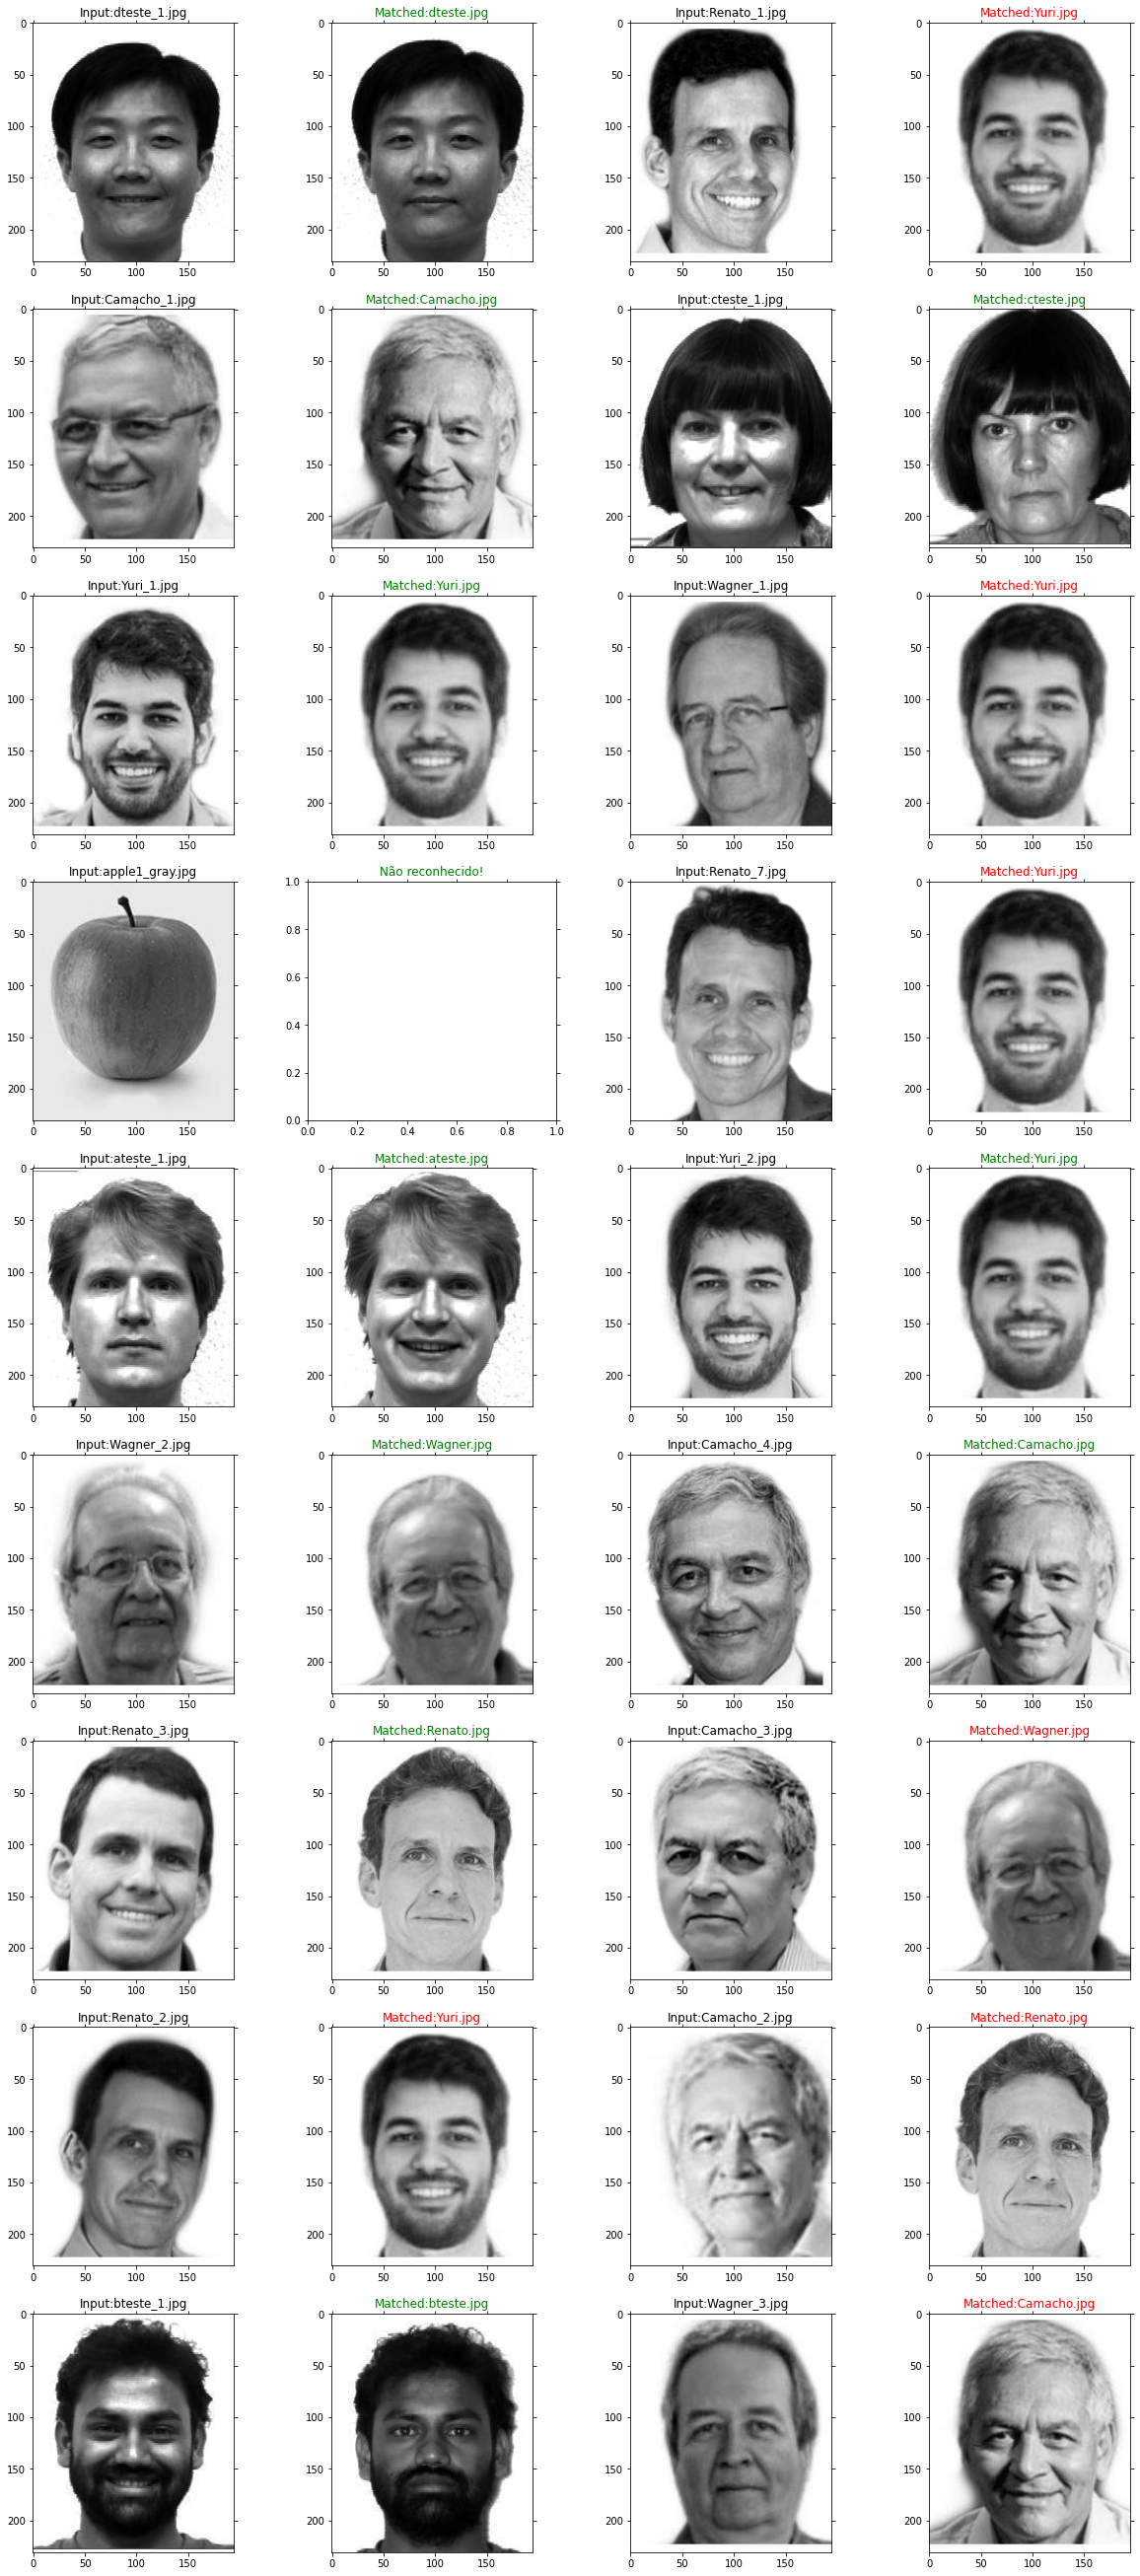

Correct predictions: 11/18 = 61.111111111111114%


In [248]:
count        = 0
num_images   = 0
correct_pred = 0
def recogniser(img, train_images,eigenfaces,weights):
    global count,highest_min,num_images,correct_pred
    face_test = plt.imread(dataset_path+img)
    num_images += 1
    face_test_v= np.array(face_test, dtype='float64').flatten()
    normalised_face_test = np.subtract(face_test_v,mean_face)
    
    plt.subplot(9,4,1+count)
    plt.imshow(face_test, cmap='gray')
    plt.title("Input:"+'.'.join(img.split('.')[:2]))
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    count+=1
    
    weights_test = np.dot(eigenfaces, normalised_face_test)
    dif  = weights - weights_test
    normas = np.linalg.norm(dif, axis=1)
    index = np.argmin(normas)
    
    t1 = 165691852
    #t1 = 120535910 # working with 6 faces
    #t0 = 40000000
    t0 = 145000000
    #t0 = 93559033 # working with 6 faces
    #t0 = 200000000
    #t1 = 300000000


    if normas[index] < t1:
        plt.subplot(9,4,1+count)
        if normas[index] < t0: # It's a face
            if img.split('_')[0] == train_images[index].split('.')[0]:
                plt.title("Matched:"+'.'.join(train_images[index].split('.')[:2]), color='g')
                plt.imshow(imread(dataset_path + train_images[index]), cmap="gray")

                correct_pred += 1
            else:
                plt.title("Matched:"+'.'.join(train_images[index].split('.')[:2]), color='r')
                plt.imshow(imread(dataset_path + train_images[index]), cmap='gray')
        else:
            if img.split('_')[0] not in [i.split('.')[0] for i in train_images]: #and img.split('.')[0] != 'apple':
                plt.title("Não reconhecido!", color="g")
                correct_pred += 1
            else:
                plt.title("Não reconhecido", color="r")
        plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
        plt.subplots_adjust(right=1.2, top=2.5)
    else:     
        plt.subplot(9,4,1+count)
        if img.split('_')[0] != "apple1":
            plt.title("Não reconhecido!", color="r")
        else:
            plt.title("Não é uma face!", color="g")
            correct_pred += 1
        plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    count+=1

fig = plt.figure(figsize=(15, 15))
for i in range(len(test_images)):
    recogniser(test_images[i], train_images,eigenfaces,weights)

plt.show()

print(f"Correct predictions: {correct_pred}/{num_images} = {correct_pred/num_images*100.00}%")

In [249]:
face_test = plt.imread("imgs/apple1_gray.jpg")
num_images += 1
face_test_v= np.array(face_test, dtype='float64').flatten()
normalised_face_test = np.subtract(face_test_v,mean_face)
weights_test = np.dot(eigenfaces, normalised_face_test)
dif  = weights - weights_test
normas = np.linalg.norm(dif, axis=1)
index = np.argmin(normas)
print(normas[index])
    

145693301.34189698
